In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: Henning Dorff
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
import Airborne_Budget_Plots as Airplots
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Retrieval functions

In [2]:
def get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=5000):
    idx_height=np.argmin(abs(np.array(retrieval_coeff_heights)-halo_height))
    relevant_height=retrieval_coeff_heights[idx_height]
    return idx_height,relevant_height

def open_height_relevant_retrieval(retrieval_coeff_heights,var_to_retrieve,act_halo_height,
                                   coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                                   "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                                   "Flight_Data\\HALO_AC3\\retrieval\\"):
    height=act_halo_height.copy()
    idx_height,relevant_height=get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=height)
    m_est_height=pd.read_csv(coeff_path+var_to_retrieve+"_Retrieval_coeffs_several_dates_"+str(relevant_height)+".csv",
                            index_col="Unnamed: 0")
    return m_est_height

## Switches and Definitions

In [3]:
campaign="HALO_AC3"
ar_of_day="AR_entire_1"
calibrated_hamp=True
flight=["RF06"]
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sector_to_plot="warm"
take_arbitary=False
do_plotting=True
plot_path=start_path+"/../plots/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

## Get the flight track data

In [4]:
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)

if ar_of_day=="AR_entire_1":
    print("load second ar section")
    with HiddenPrints():
        snd_halo_era5,delete_halo,cm,to_deleted,snd_radar,to_delete_sondes=\
            simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day="AR_entire_2")
        del delete_halo,cm, to_deleted,to_delete_sondes
else:
    snd_halo_era5=pd.DataFrame()

load second ar section


## Get Reanalysis and Model data

### ERA-5

In [5]:
import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
#IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds

### ICON

In [6]:
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
icon_resolution=2000 # units m
icon_var_list=ICON.lookup_ICON_AR_period_data(campaign,flight,ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)
halo_df=halo_df.rename(columns={"lat":"latitude",
                                "lon":"longitude"})

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
                            cmpgn_cls,icon_var_list,halo_df,flight,flight_dates[flight[0]],
                            interpolated_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv",
                            interpolated_hmc_file=None,ar_of_day=ar_of_day,
                            synthetic_icon=False,
                            synthetic_flight=False)
if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
    ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    
# ICON Values on HALO
halo_icon_hmc=ICON_on_HALO.load_hwc(with_hydrometeors=False)
halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()        
#Second ar of day
snd_ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(cmpgn_cls,icon_var_list,halo_df,flight,flight_dates[flight[0]],
                interpolated_hmp_file=flight[0]+"_"+"AR_entire_2"+"_"+"interpolated_HMP.csv",
                interpolated_hmc_file=None,ar_of_day="AR_entire_2",
                synthetic_icon=False,synthetic_flight=False)
if campaign=="HALO_AC3":
    snd_ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    # ICON Values on HALO
    snd_halo_icon_hmc=snd_ICON_on_HALO.load_hwc(with_hydrometeors=False)
    snd_halo_icon_hmp=snd_ICON_on_HALO.load_interpolated_hmp()

File of interest: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/RF06/RF06_AR_entire_1_V_Wind_interpolated_profile.csv
Changed Latitude of HALO Aircraft for Synthetic Observations
RF06_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened
File of interest: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/ICON_LEM_2KM/RF06/RF06_AR_entire_2_V_Wind_interpolated_profile.csv
Changed Latitude of HALO Aircraft for Synthetic Observations
RF06_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


### Load Budget class

In [7]:
IWV_tendency=Budgets.IWV_tendency("HALO_AC3",flight,Dropsondes,pd.DataFrame, #was retrieval IWV before
        major_work_path,flight_dates={},ar_of_day=ar_of_day)

#### Get sonde periods

In [8]:
IWV_tendency.get_relevant_sondes_dict()

### Process dropsondes

In [9]:
internal_sondes_dict=IWV_tendency.internal_sondes_dict     #pd.Timestamp("2023-03-16 16:00"))
internal_sondes_dict["warm"]           

2022-03-16 11:51:59     7
2022-03-16 17:22:12    22
dtype: int64

## Radiometer dataset

Typhon module cannot be loaded
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radiometer_unified_*20220316_v0*.nc
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc\HALO_HALO_AC3_radiometer_unified_RF06_20220316_v0.6.nc
Plotting ...
Figure saved as :  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/Flight_Data/HALO_AC3/plots/radiometer/HAMP_Tb_20220316_['RF06'].png


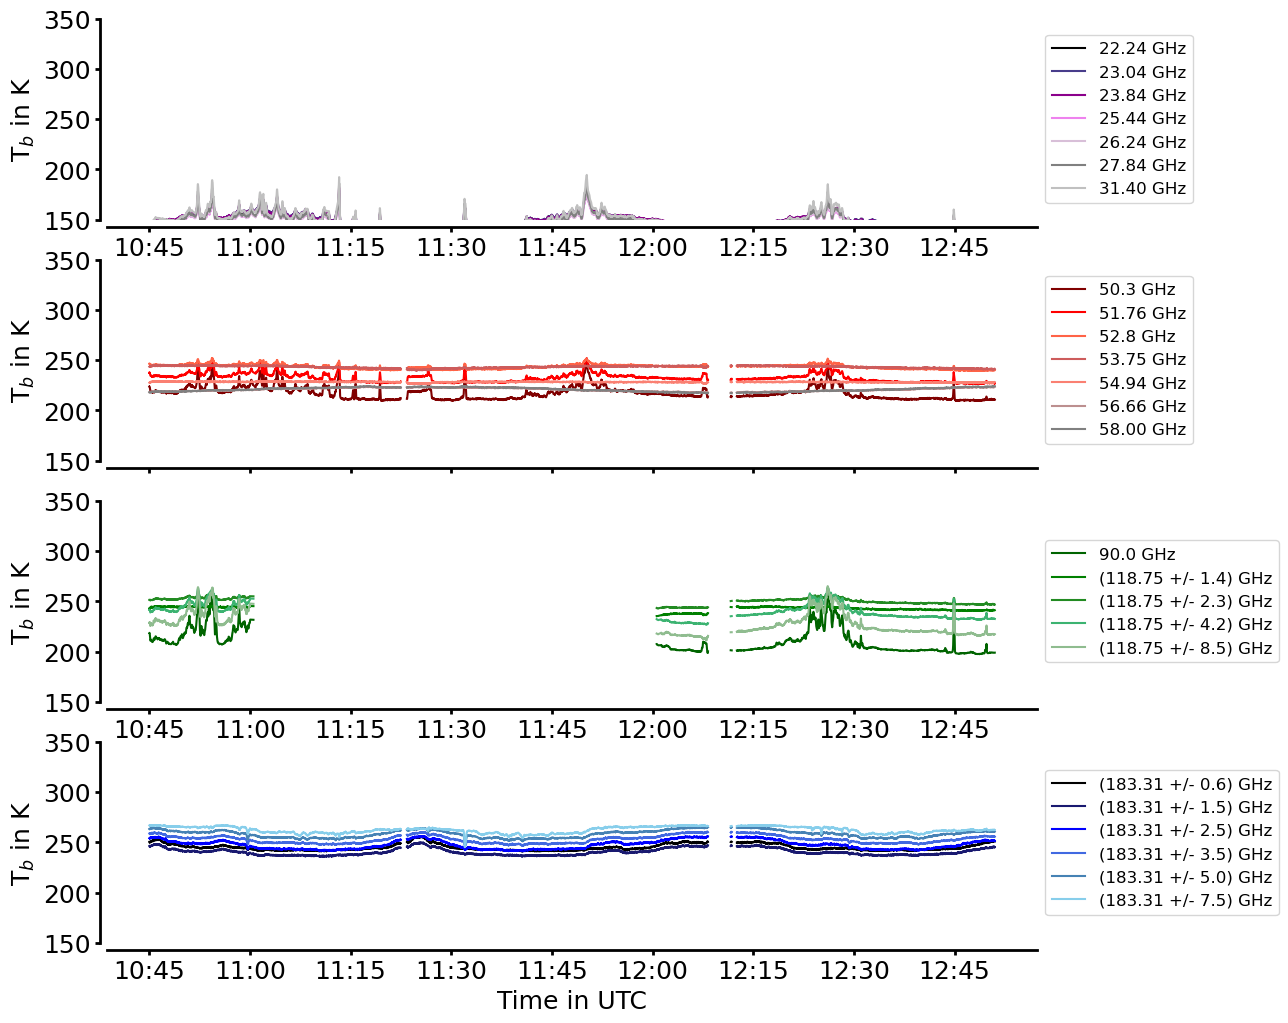

In [10]:
# processing_path packages
import data_config
import measurement_instruments_ql
import campaign_netcdf
import halodataplot as Data_Plotter
import quicklook_dicts
radar_dict={}
bahamas_dict={}  
campaign=cmpgn_cls.name
airborne_data_importer_path=major_work_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/Flight_Data/"+campaign+"/"
date=flight_dates[flight[0]]
###############################################################################
inflow=False
# Radar reflectivity
cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
cfg_dict["device_data_path"]=airborne_data_importer_path
with HiddenPrints():
    # Data Handling 
    datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
    # Get Plotting Handling
    plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                            quicklook_dicts.get_plotting_handling_attrs_dict()

HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)
Radiometer_cls=measurement_instruments_ql.HAMP(HALO_Devices_cls)
import halodataplot as halo_data_plotter
    
Quick_Plotter=Data_Plotter.Quicklook_Plotter(cfg_dict)
Radiometer_Quicklook=halo_data_plotter.Radiometer_Quicklook(cfg_dict)
calibrated_hamp=False
Radiometer_cls.open_processed_hamp_data(open_calibrated=calibrated_hamp,
                            newest_version=True)
if not calibrated_hamp:
    mwr=Radiometer_cls.processed_hamp_ds
else:
    mwr=Radiometer_cls.calib_processed_hamp_ds
if pd.Timestamp(IWV_tendency.inflow_times[0])<pd.Timestamp(IWV_tendency.outflow_times[-1]):
    mwr_cutted=mwr.sel({"time":slice(IWV_tendency.inflow_times[0],IWV_tendency.outflow_times[-1])})
else:
    mwr_cutted=mwr.sel({"time":slice(IWV_tendency.outflow_times[0],IWV_tendency.inflow_times[-1])})
Radiometer_Quicklook.radiometer_tb_dict=mwr_cutted
Radiometer_Quicklook.cfg_dict["Flight_Dates_used"]
Radiometer_Quicklook.plot_radiometer_TBs(raw_measurements=False)

### Prepare IWV Regression Retrieval

In [11]:
import retrieval
import PAMTRA_sim_analysis

# Predefinitions
coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\PhD_UHH_WIMI\\Work\\GIT_Repository"+\
            "\\hamp_processing_py\\hamp_processing_python\\Flight_Data\\HALO_AC3\\retrieval\\"
var_to_retrieve="q"
order=2

# # get all relevant retrieval heights
import glob
retrieval_coeff_files=glob.glob(coeff_path+var_to_retrieve+"*")
retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]

In [12]:
# Process brightness temperatures
brightness_Ts=pd.DataFrame(data=np.array(mwr["TB"][:]),
                           index=pd.DatetimeIndex(np.array(mwr.time[:])),
                           columns=np.array(mwr.freq[:]))
brightness_Ts=brightness_Ts.sort_index(axis=1)
# The retrieved hamp Q profiles for divergence calculations will rely on smoothened TBs
smoothed_brightness_Ts=brightness_Ts.rolling("10s",min_periods=8).mean()
# Initialize Retrieval class, most attributes are unused
regr_retrieval=retrieval.Regression_Retrieval

### IWV Retrieval

<Axes: >

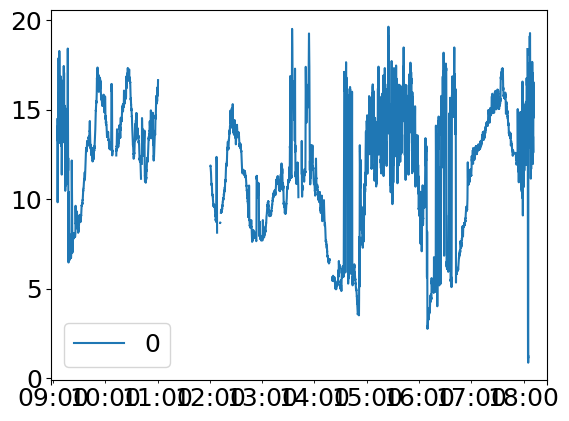

In [13]:
retrieval_coeff_path="C:\\Users\\u300737\\Desktop\\Desktop_alter_Rechner\\"+\
                                   "PhD_UHH_WIMI\\Work\\GIT_Repository\\hamp_processing_py\\hamp_processing_python\\"+\
                                   "Flight_Data\\HALO_AC3\\retrieval\\"
# Sonde retrieval
retrieved_var_file_name=retrieval_coeff_path+flight[0]+"_retrieved_IWV.csv"
if not os.path.exists(retrieved_var_file_name):
    #create IWV retrieval
    # Retrieval class
    Smoothed_IWV_Retrieval=regr_retrieval(xr.Dataset(),"IWV",smoothed_brightness_Ts,order,["20220315"],os.getcwd(),
                          added_noise=True)
    Smoothed_IWV_Retrieval.y=smoothed_brightness_Ts
    Smoothed_IWV_Retrieval.build_K_reg()

    IWV_retrieved=pd.Series(data=np.nan, index=smoothed_brightness_Ts.index)
    # Define coeff dict 
    coeff_dict_IWV={}
    IWV_retrieval_files=glob.glob(coeff_path+"IWV*")
    retrieval_coeff_heights=[int(file.split("_")[-1][:-4]) for file in retrieval_coeff_files]
    for height in retrieval_coeff_heights:
        coeff_dict_IWV[height]=pd.read_csv(coeff_path+"IWV"+"_Retrieval_coeffs_"+str(height)+".csv",
                             index_col=0)
    # loop over all timesteps
    t_range=smoothed_brightness_Ts.shape[0]
    for t in range(t_range):
        _,relevant_height=get_relevant_retrieval_height(retrieval_coeff_heights,halo_height=5000)
        coeff_IWV=coeff_dict_IWV[relevant_height]
        # coeff dict to m_est
        m_est_IWV=np.zeros(2*len(coeff_IWV.columns)+1)
        reg_coeffs=coeff_IWV.copy()
        for f, freq in enumerate(coeff_IWV.columns):
            m_est_IWV[0]=reg_coeffs.iloc[0,f]
            if f==0:
                m_est_IWV[1]=reg_coeffs.iloc[1,f]
                m_est_IWV[2]=reg_coeffs.iloc[2,f]
            else:
                m_est_IWV[2*(f+1)-1] = reg_coeffs.iloc[1,f]
                m_est_IWV[2*(f+1)]   = reg_coeffs.iloc[2,f]
        IWV_retrieved.iloc[t]=m_est_IWV.dot(Smoothed_IWV_Retrieval.K_reg[t,:].T)
        performance.updt(t_range,t)
    IWV_retrieved.to_csv(retrieved_var_file_name)
    print("IWV retrieval saved as:",retrieval_coeff_path+retrieved_var_file_name)
else:
    IWV_retrieved=pd.read_csv(retrieved_var_file_name,index_col=0)
    IWV_retrieved.index=pd.DatetimeIndex(IWV_retrieved.index)
IWV_retrieved.plot()

In [14]:
Dropsondes["IWV"]

2022-03-16 10:46:57     9.711086
2022-03-16 10:56:15    10.951782
2022-03-16 11:03:35    14.279765
2022-03-16 11:14:00    11.428132
2022-03-16 11:21:25     8.213039
2022-03-16 11:28:35     8.055237
2022-03-16 11:39:17    11.876745
2022-03-16 11:51:59    12.848947
2022-03-16 12:13:00     8.472756
2022-03-16 12:21:11    11.306042
2022-03-16 12:35:11    10.979601
2022-03-16 12:41:23     9.770020
2022-03-16 12:48:51     7.895511
2022-03-16 13:11:55     8.576490
2022-03-16 13:22:31     9.689962
2022-03-16 13:33:13    11.237836
2022-03-16 13:48:06    10.609552
2022-03-16 13:58:21    10.815460
2022-03-16 14:07:17     8.790861
2022-03-16 14:16:19     6.202451
2022-03-16 14:27:28     5.625047
2022-03-16 14:46:46     5.439603
2022-03-16 17:22:12    13.085284
dtype: float64

In [15]:
surface_index=pd.Series(data=abs(mwr["surface_mask"])<0.01,index=mwr["surface_mask"].time[:]) #IWV_retrieved[surface_index]

time_list=[str(time) for time in IWV_tendency.sonde_times_series.index]

Dropsondes["new_alt"]=Dropsondes["alt"].copy()
new_key_list=[]
half_period="6min"
# IWV from internal sondes
for key in [*Dropsondes["alt"].keys()]:
    new_key=str(pd.Timestamp(key))
    Dropsondes["alt"][new_key] = Dropsondes["alt"].pop(key)

if not flight[0]=="RF06" and not ar_of_day=="AR_entire_2":
    iwv_sonde=Dropsondes["IWV"].iloc[internal_sondes_dict[sector_to_plot]]
else:
    iwv_sonde=pd.Series(data=[Dropsondes["IWV"].loc[internal_sondes_dict[sector_to_plot].index[0]],np.nan],
                        index=internal_sondes_dict[sector_to_plot].index)

time_difference=pd.Timedelta(iwv_sonde.index[-1]-iwv_sonde.index[0],unit="minutes")
minutes_to_divide=time_difference.total_seconds()/60

In [16]:
cmpgn_cls.plot_path=os.getcwd()+"/../plots/"
HALO_AC3_Budget_Plots=Airplots.HALO_AC3_Budget_Plots(cmpgn_cls,flight,ar_of_day)

HALO_AC3_IWV_tendency=Airplots.HALO_AC3_IWV_tendency(
    cmpgn_cls,flight,ar_of_day,mwr,halo_df,
    iwv_sonde,IWV_retrieved,halo_icon_hmc,
    snd_halo_icon_hmc,halo_era5,snd_halo_era5,
    internal_sondes_dict,IWV_tendency.sonde_times_series,
    Dropsondes,sector="warm")

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/


In [17]:
hamp_iwv_internal,hamp_iwv_internal_mean=HALO_AC3_IWV_tendency.get_hamp_IWV_for_periods_around_all_sonde_locations(
    half_period=half_period)
hamp_iwv_internal_mean

2022-03-16 11:51:59    10.058836
2022-03-16 17:22:12    14.869665
dtype: float64

## Get values and uncertainties

## HALO

In [18]:
iwv_sonde

2022-03-16 11:51:59    12.848947
2022-03-16 17:22:12          NaN
dtype: float64

In [19]:
HALO_AC3_IWV_tendency.hamp_iwv_internal.min()

2022-03-16 11:51:59     8.749807
2022-03-16 17:22:12    13.881516
dtype: float64

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots/RF06_AR_entire_1_warm_hamp_sonde_iwv_comparison_twice_6min.png


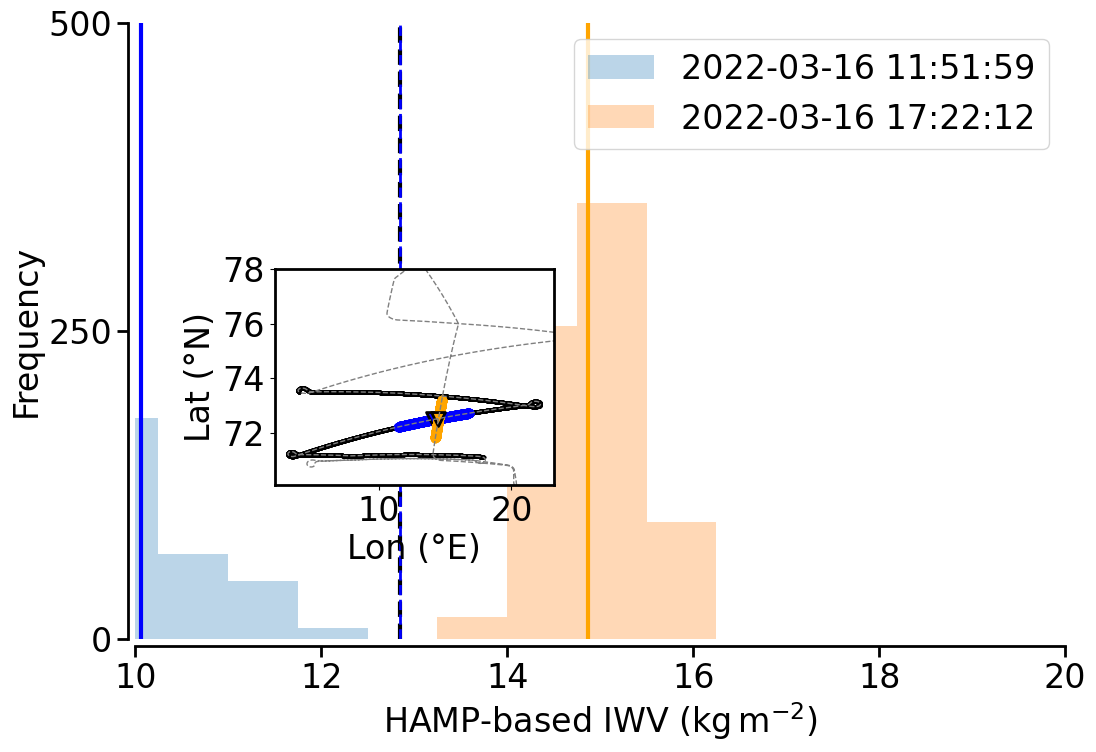

In [20]:
HALO_AC3_IWV_tendency.plot_iwv_comparison_sonde_hamp(half_period)

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots/IWV_trend_comparison_RF06_half_period_6min.png


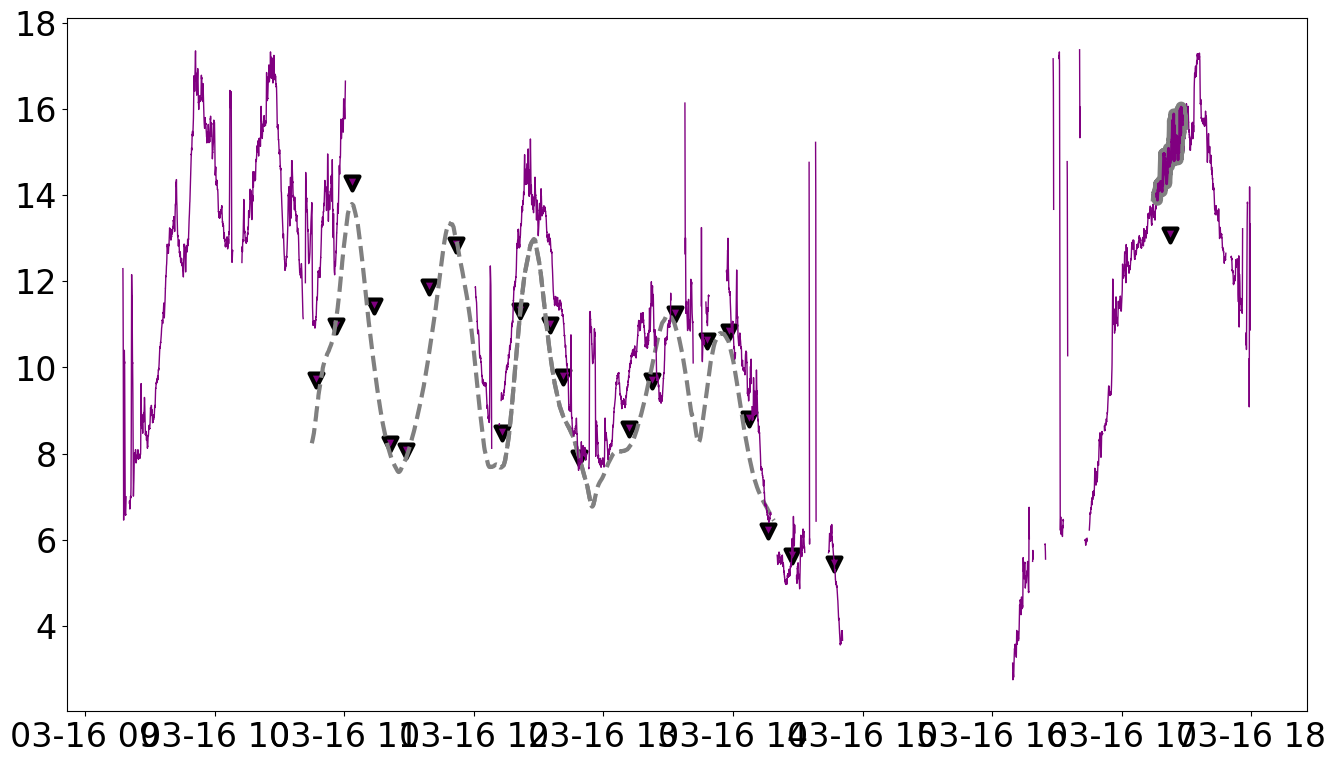

In [21]:
HALO_AC3_IWV_tendency.plot_iwv_flight_trend(surface_index,half_period)

## Uncertainty assessment

Text(0, 0.5, 'Change in IWV')

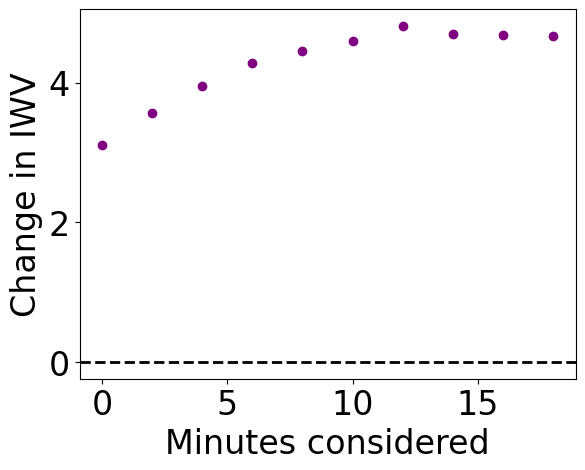

In [22]:
import matplotlib.pyplot as plt
df_hamp_internal_iwv_diff=pd.Series(data=np.nan,index=range(10))
for minute in range(10):
    half_period=str(minute)+"min"
    _,mean_IWV_values=HALO_AC3_IWV_tendency.get_hamp_IWV_for_periods_around_all_sonde_locations(half_period=half_period)
    IWV_diff=mean_IWV_values.diff()[-1]
    
    df_hamp_internal_iwv_diff.iloc[minute]=float(IWV_diff)
    plt.scatter(2*minute, df_hamp_internal_iwv_diff.iloc[minute],color="purple")
plt.axhline(y=0,xmin=0,xmax=100,color="k",ls="--",lw=2)
plt.xlabel("Minutes considered")
plt.ylabel("Change in IWV")
#mean_IWV_values

In [30]:
df_hamp_internal_iwv_diff[0:7].std()

0.6053577056092969

In [32]:
minutes_to_divide=iwv_sonde.index.to_series().diff().astype('timedelta64[m]')[-1]
mean_iwv_dt= df_hamp_internal_iwv_diff.iloc[5]/minutes_to_divide*60
std_iwv_dt = df_hamp_internal_iwv_diff.iloc[0:7].std()/minutes_to_divide*60
if flight[0]=="RF06" and ar_of_day=="AR_entire_1":
    std_iwv_dt+=std_iwv_dt/2 # Due to the large time period over 5.5 hours we add half of the uncertainty
# Stop here
iwv_rates=pd.Series(data=[mean_iwv_dt,std_iwv_dt],index=["IWV_dt","IWV_dt_unc"])

HALO_AC3_Budget_Plots.change_values_in_budget_df(iwv_rates)

IWV_dt        0.836216
IWV_dt_unc    0.165098
dtype: float64
      IWV_dt  IWV_dt_unc     ADV_q  ADV_q_unc  DIV_mass  DIV_mass_unc  \
S1 -0.767738    0.211316 -0.278493   0.139154 -0.497346      0.056066   
S2 -0.193738    0.238721 -0.553945   0.172242 -0.539671      0.075791   
S3  0.836216    0.165098  0.593545   0.140111  0.006555      0.094550   
S4  0.560422    0.090336  0.278702   0.380346  0.035408      0.105728   

      Precip  Precip_min  Precip_max      Evap  Evap_unc  
S1  0.057032    0.014287    0.123682  0.007065  0.059248  
S2  0.041188    0.007473    0.103877 -0.006380  0.062227  
S3  0.050191    0.013511    0.110727  0.056166  0.061512  
S4  0.003945    0.001085    0.010733  0.089814  0.052798  
budget df saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/Warm_Sectors_budget_components.csv


### ICON

RF06 AR_entire_2 0.5604222943936997 +/- 0.10544553439665319


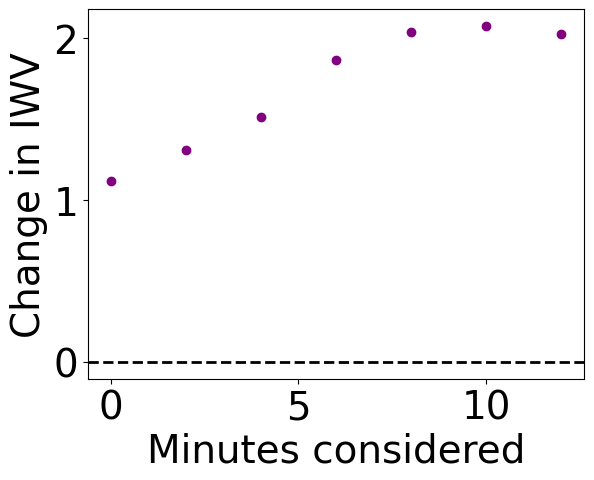

In [31]:
# ICON
icon_iwv=pd.concat([halo_icon_hmp,snd_halo_icon_hmp])
ICON_iwv_internal,ICON_iwv_internal_mean=HALO_AC3_IWV_tendency.get_hamp_IWV_for_periods_around_all_sonde_locations(
    half_period=half_period)

# Uncertainty assessment
df_icon_internal_iwv_diff=pd.Series(data=np.nan,index=range(10))
for minute in range(7):
    half_period=str(minute)+"min"
    _,mean_IWV_values=HALO_AC3_IWV_tendency.get_hamp_IWV_for_periods_around_all_sonde_locations(half_period=half_period)
    IWV_diff=mean_IWV_values.diff()[-1]
    
    df_icon_internal_iwv_diff.iloc[minute]=float(IWV_diff)
    plt.scatter(2*minute, df_icon_internal_iwv_diff.iloc[minute],color="purple")
plt.axhline(y=0,xmin=0,xmax=100,color="k",ls="--",lw=2)
plt.xlabel("Minutes considered")
plt.ylabel("Change in IWV")
#mean_IWV_values
minutes_to_divide=iwv_sonde.index.to_series().diff().astype('timedelta64[m]')[-1]
print(flight[0],ar_of_day,df_icon_internal_iwv_diff.iloc[5]/minutes_to_divide*60,"+/-",
      df_icon_internal_iwv_diff.std()/minutes_to_divide*60)

## Plotting routines
#import matplotlib
#import matplotlib.pyplot as plt
#import seaborn as sns
#import matplotlib.dates as mdates
#from matplotlib import gridspec

def get_hamp_IWV_for_periods_around_all_sonde_locations(internal_iwv_sonde,IWV_retrieved,half_period="30s"):
    #hamp_gradients using 1min mean
    hamp_iwv_internal=pd.DataFrame()
    hamp_iwv_internal_mean=pd.Series(data=np.nan,index=internal_iwv_sonde.index)
    for t,sonde_time in enumerate(internal_iwv_sonde.index):
        if flight[0]=="RF06" and ar_of_day=="AR_entire_1" and t==0:
            sonde_period_start= pd.Timestamp("2022-03-16 12:01")-pd.Timedelta(half_period)
            sonde_period_end  = pd.Timestamp("2022-03-16 12:01")+pd.Timedelta(half_period)
        else:    
            sonde_period_start= pd.Timestamp(sonde_time)-pd.Timedelta(half_period)
            sonde_period_end  = pd.Timestamp(sonde_time)+pd.Timedelta(half_period)
        temporary_series=IWV_retrieved.loc[str(sonde_period_start):\
                                                             str(sonde_period_end)]
        temporary_series.index=range(temporary_series.shape[0])
        hamp_iwv_internal[sonde_time]=temporary_series
        mean_iwv_hamp_values=IWV_retrieved.loc[str(sonde_period_start):\
                                                             str(sonde_period_end)].mean()
        hamp_iwv_internal_mean.loc[sonde_time]=mean_iwv_hamp_values.mean()
    return hamp_iwv_internal,hamp_iwv_internal_mean

def plot_internal_iwv_tendency(sonde_times_series,Dropsondes,IWV_retrieved,half_period="5min",sector_to_plot="warm"):
    # ---- Add this one : internal_sondes_dict["cold"]
    matplotlib.rcParams.update({"font.size":28})
    # Internal sondes iwv
    time_list=[str(time) for time in sonde_times_series.index]
    Dropsondes["new_alt"]=Dropsondes["alt"].copy()
    new_key_list=[]
    # IWV from internal sondes
    for key in [*Dropsondes["alt"].keys()]:
        new_key=str(pd.Timestamp(key))
        Dropsondes["alt"][new_key] = Dropsondes["alt"].pop(key)
    if flight[0]=="RF06" and ar_of_day=="AR_entire_2":
        iwv_sonde=pd.Series(data=[Dropsondes["IWV"].iloc[internal_sondes_dict[sector_to_plot][0]],np.nan],
                        index=internal_sondes_dict[sector_to_plot].index)
    else:
        iwv_sonde=Dropsondes["IWV"].iloc[internal_sondes_dict[sector_to_plot]]
    
    minutes_to_divide=iwv_sonde.index.to_series().diff().astype('timedelta64[m]')[-1]
    iwv_sonde_diff=iwv_sonde.diff()[-1]/minutes_to_divide*60

    #hamp_gradients using 1min mean
    hamp_iwv_internal,hamp_iwv_internal_mean=get_hamp_IWV_for_periods_around_all_sonde_locations(
        iwv_sonde,IWV_retrieved,half_period)
    
    hamp_iwv_diff=hamp_iwv_internal_mean.diff()/minutes_to_divide*60
    icon_iwv_diff=pd.Series(data=np.nan, index=iwv_sonde.index)
    if not flight[0]=="RF06" and ar_of_day=="AR_entire_2":
        iwv_sonde_fig=plt.figure(figsize=(8,14))
        ax1=iwv_sonde_fig.add_subplot(111)
        matplotlib.rcParams['axes.linewidth'] = 3
        ax1.patch.set_facecolor('lightgrey')
        ax1.patch.set_alpha(0.5)
        time_key_list=[*Dropsondes["q"].keys()]
        if sector_to_plot=="warm":
            colors=["darkorange","moccasin"]
        else:
            colors=["darkviolet","plum"]

        for c,sonde_time in enumerate(internal_sondes_dict[sector_to_plot]):
            if sector_to_plot=="warm":
                relevant_timestamp=time_key_list[sonde_time]
                ax1.scatter(Dropsondes["q"][relevant_timestamp]*1000,Dropsondes["alt"][str(relevant_timestamp)]/1000,
                color="k",s=140)
                ax1.scatter(Dropsondes["q"][relevant_timestamp]*1000,Dropsondes["alt"][str(relevant_timestamp)]/1000,
                    label="Sonde "+str(relevant_timestamp),color=colors[c],s=80)
                iwv_sonde=Dropsondes["q"][relevant_timestamp]
            else:
                relevant_timestamp=pd.Timestamp(sonde_time)

            icon_q_sondes={}
            icon_z_sondes={}
            if relevant_timestamp>halo_df.index[-1]:
                icon_q_sondes["Sonde"+str(c)]=snd_halo_icon_hmc["q"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                             relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
                icon_z_sondes["Sonde"+str(c)]=snd_halo_icon_hmc["Z_Height"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                                    relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
                icon_iwv_diff.iloc[c]=snd_halo_icon_hmp["Interp_IWV"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            else:
                icon_q_sondes["Sonde"+str(c)]=halo_icon_hmc["q"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                             relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
                icon_z_sondes["Sonde"+str(c)]=halo_icon_hmc["Z_Height"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                                    relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
                icon_iwv_diff.iloc[c]=halo_icon_hmp["Interp_IWV"].loc[relevant_timestamp-pd.Timedelta("1min"):\
                                                relevant_timestamp+pd.Timedelta("1min")].mean(axis=0)
            ax1.scatter(icon_q_sondes["Sonde"+str(c)]*1000,
                    icon_z_sondes["Sonde"+str(c)]/1000,
                    marker="v", s=150, color=colors[c],edgecolor="k",
                    label="ICON "+str(relevant_timestamp))
        if sector_to_plot=="warm":
            iwv_icon_diff_h=icon_iwv_diff.diff()[-1]/minutes_to_divide*60
        else:
            iwv_icon_diff_h=icon_iwv_diff.diff()[-1]/minutes_to_divide*60
        ax1.set_xlabel("Specific humidity (${\mathrm{gkg}}^{-1}$)")
        ax1.set_ylabel("Height (km)")
        ax1.set_xlim([0,5])
        ax1.set_ylim([0,12])
        if sector_to_plot=="warm":
            ax1.text(1.4,7,"$\dfrac{\delta {IWV}_{\mathrm{Sonde}}}{\delta t}=$"+str(round(iwv_sonde_diff,2))+" $\mathrm{mmh}^{-1}$",
             fontsize=25)
            ax1.text(1.4,6,"$\dfrac{\delta {IWV}_{\mathrm{ICON}}}{\delta t}=$"+str(round(iwv_icon_diff_h,2))+" $\mathrm{mmh}^{-1}$",
             fontsize=25)
            ax1.text(1.4,5,"$\dfrac{\delta {IWV}_{\mathrm{HAMP}}}{\delta t}=$"+str(round(hamp_iwv_diff[-1],2))+" $\mathrm{mmh}^{-1}$",
            fontsize=25)
        ax1.xaxis.set_tick_params(width=3,length=10)
        ax1.yaxis.set_tick_params(width=3,length=10)
        ax1.legend(fontsize=24)
        sns.despine(offset=10)
        fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_sonde_iwv_tendency_"+half_period
        fig_name+=".png"
        iwv_sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
        print("Figure saved as:",plot_path+fig_name)
    else:
        print("For ",flight[0]," ",ar_of_day, "no plotting")
    return hamp_iwv_diff

def plot_iwv_comparison_sonde_hamp(iwv_sonde,mwr,halo_df,half_period,plot_path=os.getcwd()+"/../plots/"):
    internal_map=plt.figure(figsize=(18,12))
    ax1=internal_map.add_subplot(111)
    hamp_iwv_internal.plot.hist(bins=np.linspace(5,20,11), alpha=0.3,xlim=[10,20],ax=ax1)

    ins = ax1.inset_axes([0.1,0.1,0.3,0.35])
    ins.plot(mwr["lon"],mwr["lat"],color="grey",ls="--",lw=1)
    ins.scatter(halo_df["longitude"],halo_df["latitude"],s=3,color="k")
    colors=["blue","orange"]
    for i,sonde_time in enumerate(iwv_sonde.index):
        ## Mean values
        #  Dropsondes
        if not iwv_sonde.iloc[i]==np.nan:
            ax1.axvline(x=iwv_sonde.iloc[i],lw=3,ls="--",color="k")
            ax1.axvline(x=iwv_sonde.iloc[i],lw=2,ls="--",color=colors[i])
        # HAMP
        ax1.axvline(x=hamp_iwv_internal_mean.iloc[i],lw=3,color=colors[i])

        sonde_period_start= pd.Timestamp(sonde_time)-pd.Timedelta(half_period)
        sonde_period_end  = pd.Timestamp(sonde_time)+pd.Timedelta(half_period)
        rlv_geoloc=mwr.sel({"time":slice(sonde_period_start,sonde_period_end)})
        sonde_lon=mwr["lon"].sel({"time":sonde_time})
        sonde_lat=mwr["lat"].sel({"time":sonde_time})
        ins.scatter(rlv_geoloc["lon"],rlv_geoloc["lat"],color=colors[i])
        ins.scatter(sonde_lon,sonde_lat, s=100, marker="v",color=colors[i],lw=2,edgecolor="k")
        ins.set_xlim([halo_df["longitude"].min()-1,halo_df["longitude"].max()+1])
        ins.set_ylim([halo_df["latitude"].min()-1,halo_df["latitude"].max()+1])
    ax1.set_xlabel("HAMP-based IWV / $\mathrm{kg}\,\mathrm{m}^{-2}$")
    sns.despine(ax=ax1,offset=5)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_hamp_sonde_iwv_comparison"+"_twice_"+half_period+".png"
    internal_map.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

# Compare sondes and HAMP IWV with ERA5
def plot_iwv_flight_trend(sonde_times_series,Dropsondes,halo_era5,snd_halo_era5,IWV_retrieved,surface_index,half_period,                         plot_path=os.getcwd()+"/../plots/"):
    iwv_trend=plt.figure(figsize=(16,9))
    plt.scatter(sonde_times_series.index,Dropsondes["IWV"],s=100,marker="v",lw=3,edgecolor="k",color="purple",label="Sondes")
    plt.plot(halo_era5.index,halo_era5["Interp_IWV"],color="grey",lw=3,label="ERA5",ls="--")
    if not snd_halo_era5==None:
        plt.plot(snd_halo_era5.index,snd_halo_era5["Interp_IWV"],color="grey",lw=3,label="ERA5",ls="--")
    sea_IWV_retrieved=IWV_retrieved.copy()
    sea_IWV_retrieved[~surface_index]=np.nan
    plt.plot(sea_IWV_retrieved.index,sea_IWV_retrieved,color="purple",lw=1,label="HAMP")
    for i,sonde_time in enumerate(iwv_sonde.index):
        if i > 0 and flight[0]!="RF06" and ar_of_day!="AR_entire_2":
            plt.scatter(sonde_time,Dropsondes["IWV"].loc[sonde_time],marker="o",facecolors="none",edgecolor="k",lw=3,s=300)
        sonde_period_start= pd.Timestamp(sonde_time)-pd.Timedelta(half_period)
        sonde_period_end  = pd.Timestamp(sonde_time)+pd.Timedelta(half_period)
        rlv_geoloc=mwr.sel({"time":slice(sonde_period_start,sonde_period_end)})
        plt.plot(rlv_geoloc.time,IWV_retrieved.loc[rlv_geoloc.time],color="grey",lw=8)
        plt.plot(rlv_geoloc.time,IWV_retrieved.loc[rlv_geoloc.time],color="purple",lw=2)
    fig_name="IWV_trend_comparison_"+flight[0]+"_half_period_"+half_period
    fig_name+=".png"
    iwv_trend.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
